In [1]:
from ultralytics import YOLO
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from ollama import chat
from ollama import ChatResponse
torch.cuda.get_device_name(0)
import os

In [3]:
final_project = YOLO("best8.pt",task='detect')

In [6]:
#Images sourced from the internet for testing deployed model:
# image_files = ["tests/Test_Model_1.jpeg", "tests/Test_Model_2.jpeg", "tests/Test_Model_3.jpeg", "tests/Test_Model_4.jpeg", "tests/Test_Model_5.jpeg"]
image_files = ["tests/Test_Model_8.png"]

In [8]:
def image_rect(img):
    re_img = cv2.resize(img, (780, 540),
                        interpolation=cv2.INTER_LINEAR)
    copy_re_img = re_img.copy()
    # cv2.imshow("copy_re_img", copy_re_img)
    gray = cv2.cvtColor(re_img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(
        gray, 150, 180, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    plt.figure(figsize=(10, 10))
    plt.imshow(thresh, cmap='gray')
    plt.axis('off')
    plt.show()

    canny = cv2.Canny(thresh, 50, 100)
    plt.figure(figsize=(10, 100))
    plt.imshow(canny, cmap='gray')
    plt.axis('off')
    plt.show()
    contours = cv2.findContours(
        canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

    contours = sorted(contours, key=lambda x: cv2.contourArea(x),
                      reverse=True)[:10]

    points = []
    for c in contours:
        epsilon = 0.05 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        if len(approx) == 4:
            if cv2.contourArea(approx) > 130000:
                cv2.drawContours(re_img, [approx], 0, (0, 255, 0), 3)
                for point in approx:
                    points.append((point[0][0], point[0][1]))
    if len(points) == 0:
        # thresh = cv2.dilate(thresh, np.ones((3, 3), np.uint8), iterations=4)
        # thresh = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=4)
        # thresh = cv2.dilate(thresh, np.ones((3, 3), np.uint8), iterations=2)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE,
                              np.ones((7, 7), np.uint8))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
                                np.ones((13, 13), np.uint8))
        # plt.figure(figsize=(10, 10))
        # plt.imshow(thresh, cmap='gray')
        # plt.axis('off')
        # plt.show()
        canny = cv2.Canny(thresh, 50, 100)
        # plt.figure(figsize=(10, 100))
        # plt.imshow(canny, cmap='gray')
        # plt.axis('off')
        # plt.show()
        contours = cv2.findContours(
            canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

        contours = sorted(contours, key=lambda x: cv2.contourArea(x),
                        reverse=True)[:10]
        for c in contours:
            epsilon = 0.05 * cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, epsilon, True)
            if len(approx) == 4:
                if cv2.contourArea(approx) > 130000:
                    cv2.drawContours(re_img, [approx], 0, (0, 255, 0), 3)
                    for point in approx:
                        points.append((point[0][0], point[0][1]))
    try:
        menor_y = min(points, key=lambda p: p[1])[0]
        x_points = [p[0] for p in points]
        y_points = [p[1] for p in points]
        x_points.sort()
        y_points.sort()
        if menor_y <= x_points[0]+90:
            print("menor_y")
            pts1 = np.float32([[x_points[1], y_points[0]], [x_points[3], y_points[1]],
                               [x_points[0], y_points[2]], [x_points[2], y_points[3]]])
        else:
            print("menor_x")
            pts1 = np.float32([[x_points[0], y_points[1]], [x_points[2], y_points[0]],
                               [x_points[1], y_points[3]], [x_points[3], y_points[2]]])
        pts2 = np.float32([[0, 0], [x_points[3]-x_points[0], 0], [0, y_points[3]-y_points[0]], [x_points[3]-x_points[0], y_points[3]-y_points[0]]])
        # cv2.circle(copy_re_img, (630, 218), 5, (0, 0, 255), -1)
        # cv2.circle(copy_re_img, (int(points[3][0]),
        #            int(points[3][1])), 5, (0, 0, 255), -1)
        # cv2.imshow("copy_re_img", copy_re_img)
        M = cv2.getPerspectiveTransform(pts1, pts2)
        dst = cv2.warpPerspective(copy_re_img, M, (x_points[3]-x_points[0], y_points[3]-y_points[0]))
        plt.figure(figsize=(10, 10))
        plt.imshow(dst)
        plt.axis('off')
        plt.show()
        plt.figure(figsize=(10, 10))
        plt.imshow(re_img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print("Error:", e)


image 1/1 /home/hinfinity/Documents/bird-eye/tests/Test_Model_8.png: 352x640 3 Autos, 2 Placas, 4.9ms
Speed: 18.3ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


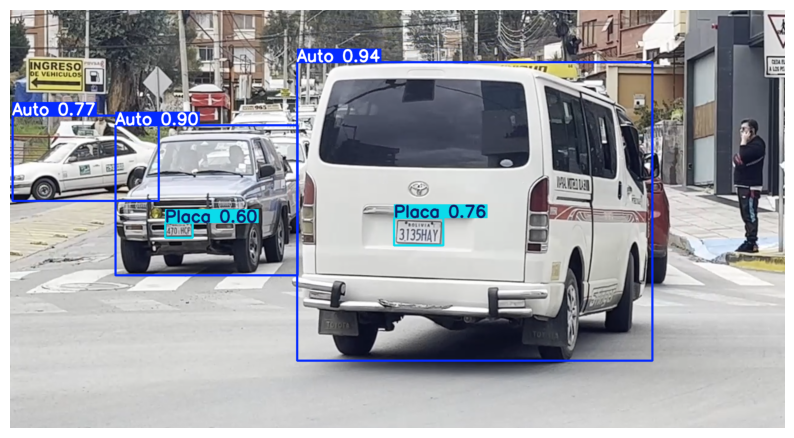

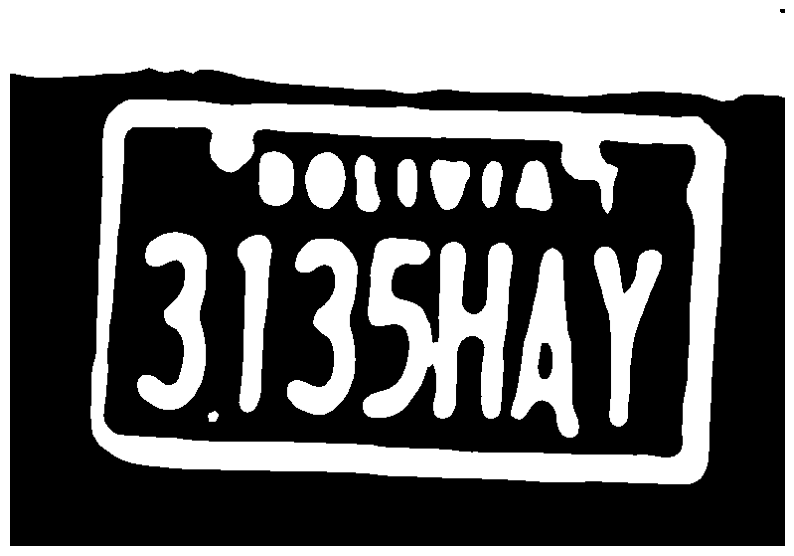

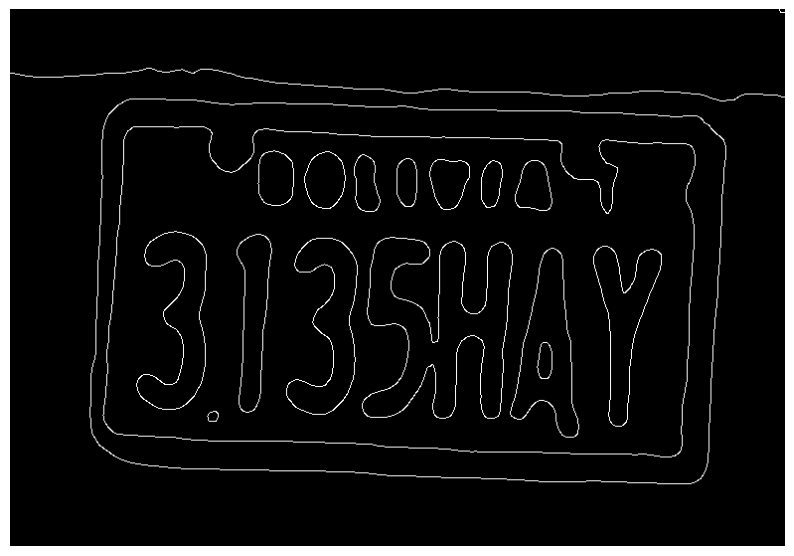

menor_y


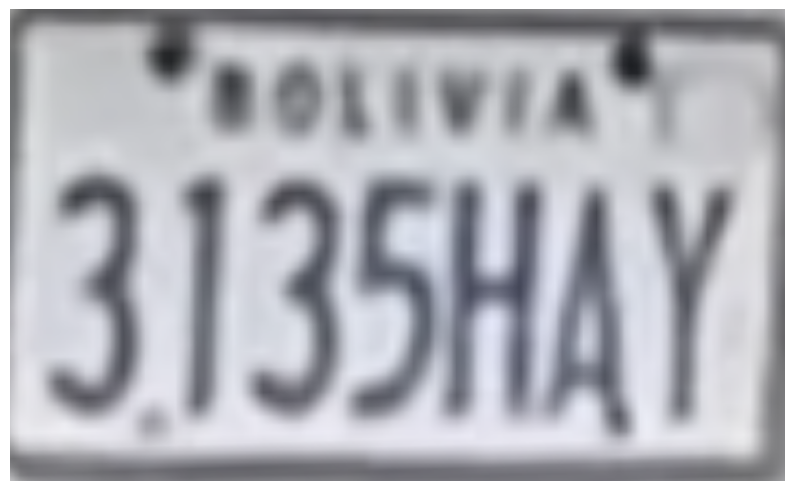

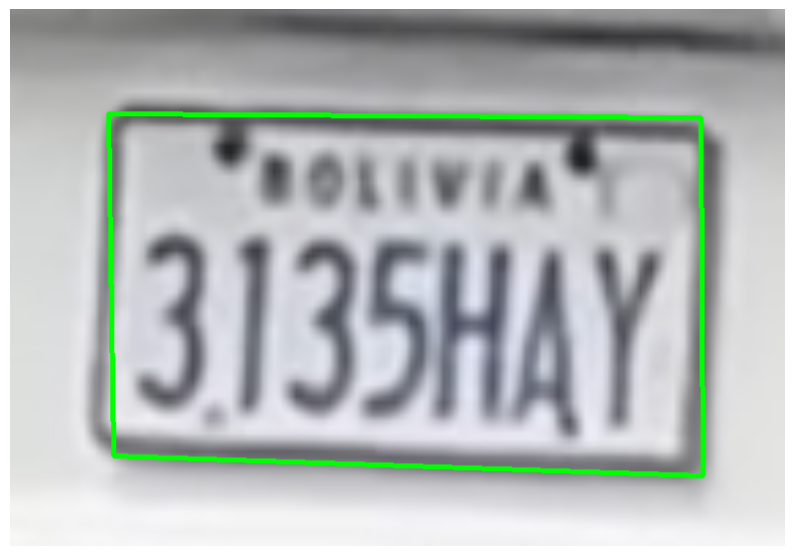

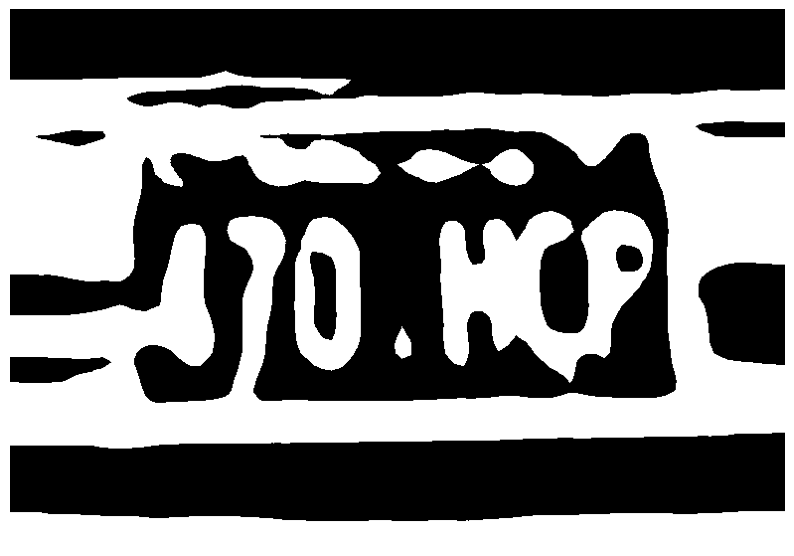

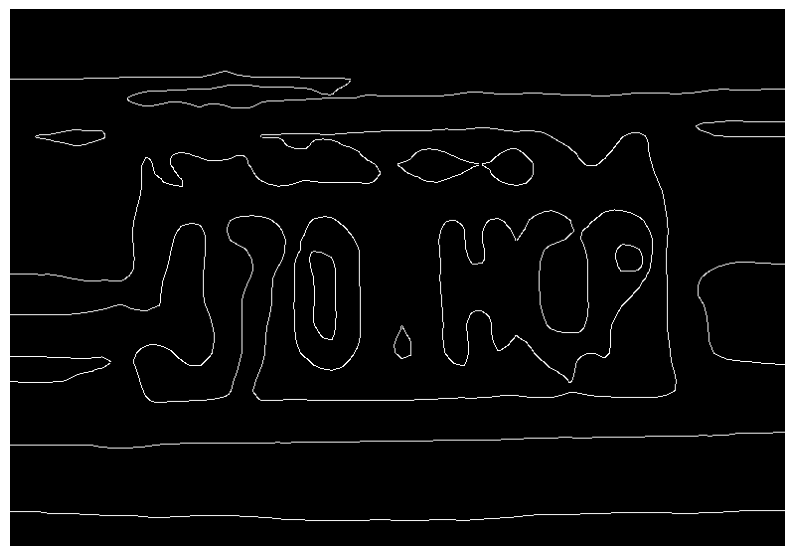

Error: min() iterable argument is empty


In [9]:
path = "img/plate.jpg"
for image_file in image_files:
    results = final_project(image_file)
    for i, r in enumerate(results):
        im_bgr = r.plot()
        im_rgb = cv2.cvtColor(im_bgr,cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(im_rgb)
        plt.axis('off')
        plt.show()

        plates = [plate[:4].tolist() for plate in r.boxes.data if plate[5] == 1]
        for plate in plates:
            x1, y1, x2, y2 = plate
            im = cv2.imread(image_file)
            im = im[int(y1)-10:int(y2)+10, int(x1)-10:int(x2)+10]
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            # cv2.imwrite(path, im)
            # response: ChatResponse = chat(model='gemma3:4b', messages=[
            # {
            #     'role': 'user',
            #     'content': 'Read the plate from the image:',
            #     'images': [path],
            # },
            # ])
            # os.remove(path)
            # print(response['message']['content'])
            image_rect(im)
